This notebook contains all relevant code to visualize both datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import pickle
import os
import matplotlib.pyplot as plt
import re
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import shapiro

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [2]:
# Load data
try:
    with open("data/static_05_12_23/raw/static_full.pkl", "rb") as f:
        df_static = pickle.load(f)
    with open("data/static_05_12_23/processed/train_static_merged.pkl", "rb") as f:
        df_merged = pickle.load(f)
except FileNotFoundError:
    os.chdir('../')
    with open("data/static_05_12_23/raw/static_full.pkl", "rb") as f:
        df_static = pickle.load(f)
    with open("data/static_05_12_23/processed/train_static_merged.pkl", "rb") as f:
        df_merged = pickle.load(f)

In [3]:
df_static.head()

,gameDuration,gameCreation,gameVersion,mapId,queueId,patch,seasonId,platformId,participant1_level,participant1_champion_championNumber,...,participant10_kills,participant10_deaths,participant10_assists,participant10_lp,participant10_maxKills,participant10_cs,participant10_damage,participant10_gold,participant10_teamId,participant10_win
0,1157,1697021737080,13.20.535.2535,11,420,20,13,BR1,988,83,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,200,True
0,1770,1697028305954,13.20.535.2535,11,420,20,13,BR1,121,150,...,1.5,4.4,14.6,59,12,35.2,6091.0,7358.0,200,True
0,2308,1697031146651,13.20.535.2535,11,420,20,13,BR1,739,164,...,2.0,4.7,12.3,109,10,35.7,9140.0,7780.0,200,True
0,1838,1697030634954,13.20.535.2535,11,420,20,13,BR1,841,54,...,0.7,4.6,14.3,152,11,12.4,3761.0,7062.0,200,True
0,1668,1697033782100,13.20.535.2535,11,420,20,13,BR1,766,24,...,5.5,6.8,8.6,294,16,38.5,20301.0,9051.0,200,False


In [4]:
def merge_columns(df: pd.DataFrame) -> dict:
    """
    Merges columns of the form participant<x>_<col> to participants_<col>
    :param df: 
    :return: 
    """
    cols = df.columns.tolist()
    merged_columns = {}
    for col in cols:
        matches = re.search("participant(\d)_(\w+)", col)
        if matches:
            col_type = matches.group(2)
            if col_type not in merged_columns:
                merged_columns[col_type] = []
            merged_columns[col_type].append(df[col])
    merged_series = {}
    # Merge the columns of the same type into a single Pandas Series for each type
    for col_type, data_list in merged_columns.items():
        merged_series[col_type] = pd.concat(data_list, axis=1)
        # Merge all columns into a single list (flatten the DataFrame)
        merged_series[col_type] = merged_series[col_type].values.flatten()
    return merged_series

## Visualize general columns

this needs to be done upfront, as later these columns get cleaned away

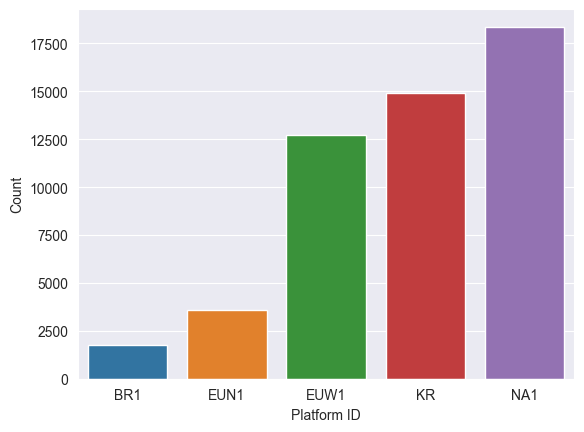

In [5]:
# plot platforId distribution
ax = sns.countplot(x='platformId', data=df_static)
ax.set(xlabel='Platform ID', ylabel='Count')
plt.savefig('thesis/images/platformId_distribution.pgf')

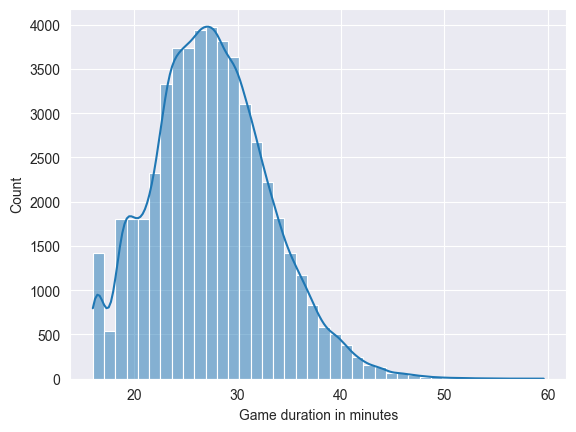

In [6]:
# plot game duration distribution
gameDurationMinutes = df_static['gameDuration'] / 60
ax = sns.histplot(gameDurationMinutes, bins=40, kde=True)
ax.set(xlabel='Game duration in minutes', ylabel='Count')
plt.savefig('thesis/images/gameDuration_distribution.pgf')

In [7]:
res = shapiro(gameDurationMinutes.sample(50))
res

ShapiroResult(statistic=0.9491937160491943, pvalue=0.031612761318683624)

In [8]:
res = lilliefors(gameDurationMinutes[:100], dist='norm', pvalmethod='table')
res

(0.04998205901330166, 0.7807945783343234)

In [9]:
gameDurationMinutes.describe()

count    51360.000000
mean        27.502848
std          5.687847
min         16.000000
25%         23.566667
50%         27.216667
75%         31.087500
max         59.616667
Name: gameDuration, dtype: float64

In [10]:
type(gameDurationMinutes)

pandas.core.series.Series

<Axes: >

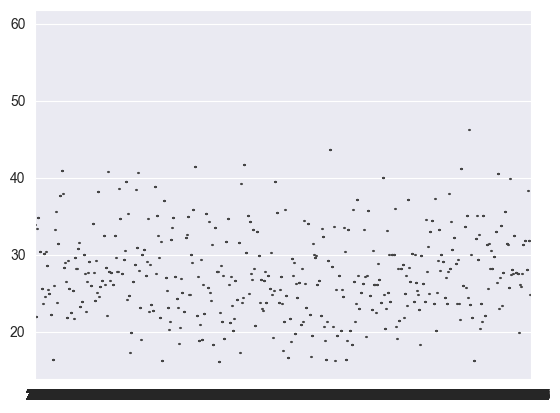

In [11]:
# plot game duration distribution
sns.boxplot(data=gameDurationMinutes)

## Visualize participant columns

In [18]:
merged = merge_columns(df_static)
merged.keys()

dict_keys(['level', 'champion_championNumber', 'champion_infoAttack', 'champion_infoDefense', 'champion_infoMagic', 'champion_infoDifficulty', 'champion_tier', 'champion_win_rate', 'champion_pick_rate', 'champion_ban_rate', 'champion_matches', 'tier', 'rank', 'leaguePoints', 'wins', 'losses', 'veteran', 'inactive', 'freshBlood', 'hotStreak', 'lastPlayTime', 'championLevel', 'championPoints', 'championPointsSinceLastLevel', 'tokensEarned', 'kda', 'kills', 'deaths', 'assists', 'lp', 'maxKills', 'cs', 'damage', 'gold', 'teamId', 'win'])

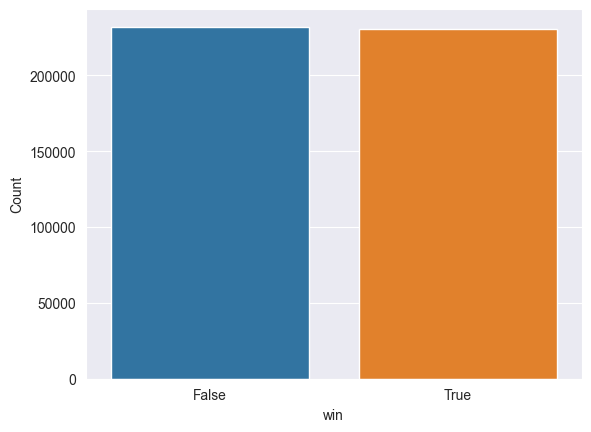

In [19]:
for key, value in merged.items():
    df_to_plot = pd.DataFrame(value)
df_to_plot.columns = [key]
ax = sns.countplot(x=key, data=df_to_plot)
ax.set(xlabel=key, ylabel='Count')
plt.show()

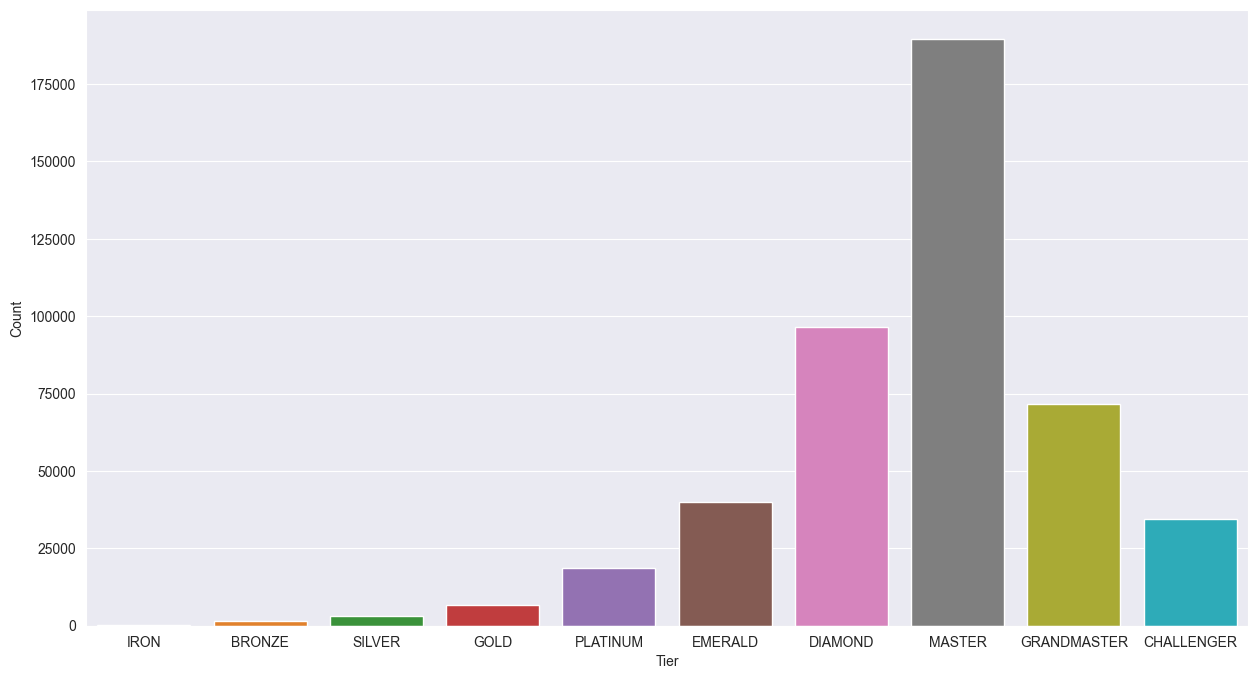

In [20]:
# TODO: change colors to match rank colors
df_tier = pd.DataFrame(merged['tier'])
df_tier.columns = ['tier']
plt.figure(figsize=(15, 8))
ax = sns.countplot(df_tier, x='tier', orient='y',
                   order=['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER', 'GRANDMASTER',
                          'CHALLENGER'])
ax.set(xlabel='Tier', ylabel='Count')
plt.savefig('thesis/images/tier_distribution.pgf')

In [15]:
df_merged.head()

,level_team1,level_team2,champion_infoAttack_team1,champion_infoAttack_team2,champion_infoDefense_team1,champion_infoDefense_team2,champion_infoMagic_team1,champion_infoMagic_team2,champion_infoDifficulty_team1,champion_infoDifficulty_team2,...,championNumber_711,championNumber_777,championNumber_875,championNumber_876,championNumber_887,championNumber_895,championNumber_897,championNumber_902,championNumber_950,label
0,-1.155044,0.985084,1.455596,0.769146,1.525367,-0.702230,-0.621111,-1.488401,0.218414,0.427119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.296515,-1.575115,-0.810266,0.323316,0.051365,1.515794,0.679943,-3.001602,1.087644,-1.972868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.913868,0.057534,1.229010,0.323316,0.297032,-0.455783,-0.187426,0.457142,-1.302740,2.608926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.964336,-0.512747,0.096079,-1.014177,-1.668305,0.776452,0.246259,1.321828,1.304952,-0.009242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.983198,0.919023,1.002424,0.323316,-0.685636,0.530005,0.679943,-0.839887,-0.433509,-1.100145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualize averaged team columns